In [2]:
%matplotlib inline

import pandas as pd
import os
import csv
import numpy as np
import random
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn import manifold, datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

In [3]:
cur_dir = os.path.dirname('__file__')
data = pd.read_csv(os.path.join(cur_dir, "WDI_Data.csv"))

In [4]:
def preprocess(df):
    """Create a 21st column, which is the average of a certain stat since the year 2000."""
    df = df.copy()
    df['21st'] = df.ix[:, '2000':].mean(axis=1)
    return df

In [5]:
def one_year(data, year='21st'):
    """Averages all statistics over the course of the 21st century, and create a dataframe where each
    row is a country, and each column is a statistic.
    """
    grouped = data.groupby('Indicator Name')
    indic_dict = {}
    for indicator, group in grouped:
        for index, row in group.iterrows():
            if indicator not in indic_dict:
                indic_dict[indicator] = []
            indic_dict[indicator].append(row[year])
    for indicator, group in grouped:
        names = group['Country Name'].tolist()
        break   
        
    return pd.DataFrame(indic_dict, index=names)


def only_countries(df, n=None):
    """Filter the input df and remove all rows that do not represent a country. (For example, there is one row the
    World.)"""
    if n is None:
        n = len(df)
    words = ['World', 'income', '(developing only)', 'OECD', 'countries', 'Euro', 'Asia', 'America', 'situations', 'states']
    sel = []
    for i in df.index:
        temp = True
        for w in words:
            if w in i:
                temp = False
        sel.append(temp)
        
    return df[sel].iloc[:n]

def few_na_cols(df, thresh=0, required_countries=[]):
    """Remove all columns that do not have thresh proportion of values filled in. required_countries are countries that
    must have a value in a column for it to be kept."""
    res = []
    for c in df.columns:
        perc = null_pct(df[c])
        meets_required = True
        for count in required_countries:
            if df[c].isnull().loc[count]:
                meets_required = False
        if perc >= thresh and meets_required:
            res.append(c)
    return df[res]

def highest_pop_df(df, n=None, by='Population, total'):
    """Return the dataframe, sorted by population."""
    if n is None:
        n = len(df)
    df = df.sort_values(by,ascending=False)
    return df.iloc[:n]

def null_pct(col):
    return float(col.notnull().sum()) / len(col)

def get_unique_cols(df, thresh=0.95):
    uniques = df.columns.tolist()
    corr_df = df.corr()
    i = 0
    while i < len(uniques):
        j = 0
        while j < len(uniques):
            if i != j:
                col1 = uniques[i]
                col2 = uniques[j]
                r_sq = corr_df[col1].loc[col2] ** 2
                if r_sq >= thresh:
                    if null_pct(df[col1]) > null_pct(df[col2]):
                        drop_index = j
                    elif null_pct(df[col1]) < null_pct(df[col2]):
                        drop_index = i
                    else:
                        drop_index = random.choice([i, j])
                    uniques.pop(drop_index)
                    if drop_index == i:
                        i = i - 1
                        break
            j += 1
        i += 1
    return uniques
                    
                
    corr = df.corr()
    for col in corr:
        corr[col].loc[col]
        break
        

def get_data_availability(df):
    """Get a dataframe containing the percentage of rows for each column that is not NaN"""
    null_pcts = []

    for column in df.columns:
        col = df[column]
        n = null_pct(col)
        null_pcts.append(n)


    temp = pd.DataFrame(data=null_pcts, index=df.columns,
                        columns=['Data Availability']).sort_values('Data Availability', ascending=False)
    return temp

In [6]:
def create_group_csv(csv_dwnld, save_to):
    """Call this function after downloading a csv for a single country, for a single year, for a group of indicators.
    This function exports the indicator names to a csv."""

    data = pd.read_csv(os.path.join(cur_dir, csv_dwnld))
    education_stats = data['Series Name'].tolist()

    with open(save_to, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(education_stats)
        
def get_indicator_list_from_csv(csv_file):
    """And then this gets the corresponding indicator list from the csv."""
    with open(csv_file) as f:
        reader = csv.reader(f)
        your_list = list(reader)
    l = your_list[0]
    l = [s for s in l if s != "nan"]
    return l

"""
# example usage
create_group_csv('Data_Extract_From_World_Development_Indicators_Data.csv', 'health.csv')
health_indicators = get_indicator_list_from_csv('health.csv')
"""

"\n# example usage\ncreate_group_csv('Data_Extract_From_World_Development_Indicators_Data.csv', 'health.csv')\nhealth_indicators = get_indicator_list_from_csv('health.csv')\n"

In [23]:
def cluster_label_dict(countries, clustering):
    """Takes in a list of countries and a cluster, and returns a dictionary mapping from cluster to a list
    of countries in that cluster"""
    label_dict = {}

    for index, label in enumerate(clustering.labels_):
        label_dict[countries[index]] = label
    return label_dict

def cluster_highest_pop_countries(df, features, n=30, m=3):
    """This helper function clusters the highest n populated countries into m clusters. It returns the cluster, a
    cluster dictionary creating using cluster_label_dict(), X_red - a spectrical embedding of the data into two dimensions,
    and the list of countries."""
    
    highest_pop = highest_pop_df(df)[features]
    highest_pop = highest_pop[get_unique_cols(highest_pop)]

    countries = only_countries(highest_pop, n=n)
    economics = few_na_cols(countries, thresh=1)

    sample = economics.dropna()
    countries = sample.index
    
    X = sample.as_matrix()
    X = StandardScaler().fit_transform(X)
    n_samples, n_features = X.shape

    X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)

    clustering = AgglomerativeClustering(linkage='ward', n_clusters=m)
    clustering.fit(X_red)
    clust_dict = cluster_label_dict(countries, clustering)
    
    return clustering, clust_dict, X_red, countries

def plot_clustering(X_red, clustering, countries, title=None):
    """Plots a clustering of countries. Takes in X_red, the cluster object, and the list of countries."""
    labels = clustering.labels_
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(countries[i])[:3],
                 color=plt.cm.spectral(labels[i] / float(len(set(labels)) - 1)),
                 fontdict={'weight': 'bold', 'size': 15})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()
    
def plot_map(clust_dict):
    '''Use dict of labels and clusters of countries to create a world map color-coded by label'''
    
    #Create map object and load world countries Shapefiles
    m = Basemap(projection='mill')
    m.readshapefile('Borders/world', name='countries', drawbounds=True)
    
    country_names = [shape_dict['NAME'] for shape_dict in m.countries_info]
    label_color = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'yellow', 6:'pink'}
    ax = plt.gca()
            
    for country, label in clust_dict.iteritems():
        color = label_color[label]
        #Countries with non-contiguous landmasses are constructed as multiple polygons
        country_indices = [i for i, c in enumerate(country_names) if c.lower() in country.lower()]
        segs = [m.countries[index] for index in country_indices]
        polys = [Polygon(seg, facecolor=color, edgecolor=color) for seg in segs]
        [ax.add_patch(poly) for poly in polys]
        
#     m.drawmapboundary(fill_color='aqua')
    plt.gcf().set_size_inches(20,10)
    plt.show()
    return country_names

In [24]:
data = preprocess(data) # create the 21st column

In [25]:
df = one_year(data) # create a dataframe using the 21st columns

In [26]:
# create our feature lists

features = {}
groups = ['health', 'education', 'economics']

for g in groups:
    features[g] = get_indicator_list_from_csv(g + '.csv')

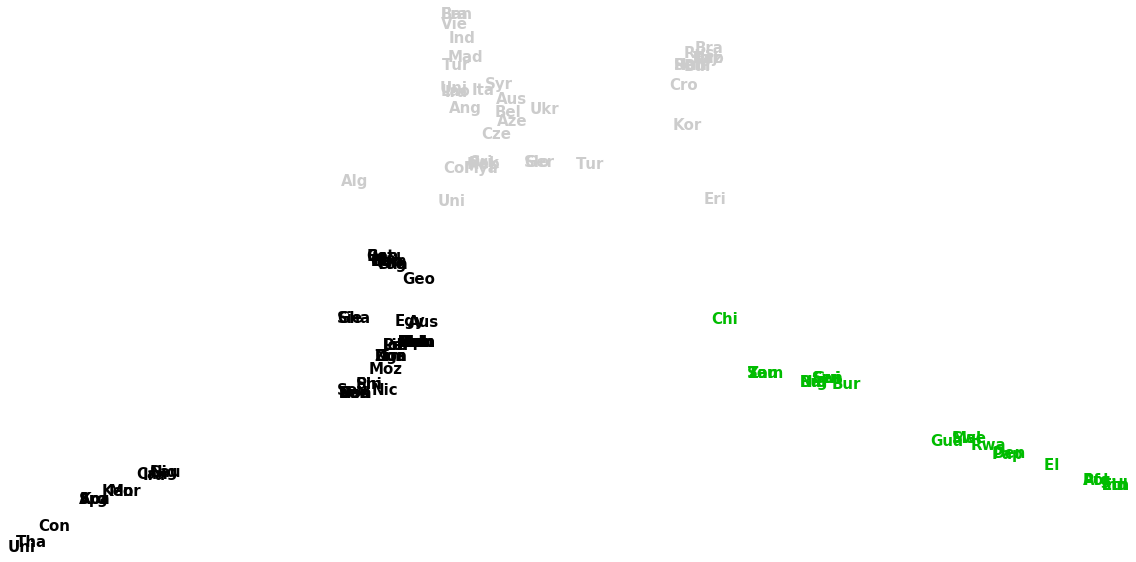

In [31]:
# plot the cluster for economics
clust, dic, X_red, countries = cluster_highest_pop_countries(df, features['education'], n=120, m=3)
plot_clustering(X_red, clust, countries)
plt.gcf().set_size_inches(16, 8)

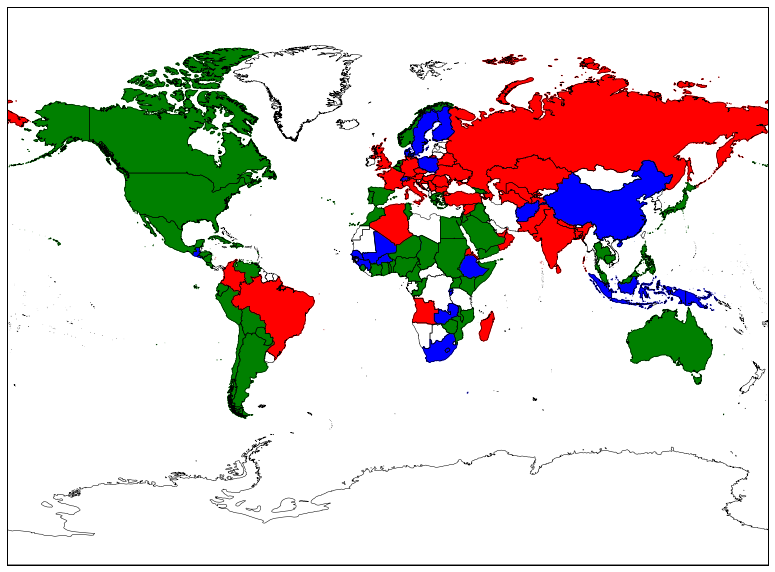

In [32]:
c_names = plot_map(dic)